# Penalty kicks 

This notebook analyzes the penalty kick data as a simultaneous move game of complete information. The data come from English premier league games in 2016-17. 

**Data source:** https://www.kaggle.com/mauryashubham/english-premier-league-penalty-dataset-201617

In [1]:
import pandas as pd 
import numpy as np 
import nashpy as n
import matplotlib.pyplot as plt 

Global settings for pandas printing floats with two decimals. 

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
def print_payoffs(U, A): 
    '''print_payoffs: Nicely formatted for a 2*2 game 
        INPUTS: 
            U1,U2: (matrices, dim=na1*na2) Payoffs 
            A1: (list of str, len=na1) List of actions of player 1
            A2: (list of str, len=na2) list of actions of player 2
        
        OUTPUT:
            tab: pandas dataframe, na1*na2 with payoff tuples 
    '''
    assert len(U) == 2, f'only implemented for 2-player games'
    assert len(A) == 2, f'only implemented for 2-player games'

    U1 = U[0]
    U2 = U[1]
    A1 = A[0]
    A2 = A[1]

    na1,na2 = U1.shape
    assert len(A1) == na1
    assert len(A2) == na2

    # "matrix" of tuples 
    X = [[(U1[r,c],U2[r,c]) for c in range(na2)] for r in range(na1)]

    # dataframe version 
    tab = pd.DataFrame(X, columns=A2, index=A1)
    
    return tab 

In [4]:
dat = pd.read_csv('penalty_data.csv', encoding='latin')

In [5]:
dat['Date'] = pd.to_datetime(dat.Date)

In [6]:
print(f'Penalty kicks from games: ')
dat.Date.dt.year.value_counts()

Penalty kicks from games: 


2016    63
2017    43
Name: Date, dtype: int64

In [7]:
dat.head(3)

,No.,Match Week,Date,Player,Team,Match,Time of Penalty Awarded,Scored,Final Results,Foot,Kick_Direction,Keeper_Direction,Saved
0,1,1,2016-08-13,Riyad Mahrez,Leicester,Hull vs Leicester,47' minute,Scored,42737,L,C,R,NaN
1,2,1,2016-08-13,Sergio Agüero,Man City,Man City vs Sunderland,4' minute,Scored,42737,R,L,L,NaN
2,3,1,2016-08-14,Theo Walcott,Arsenal,Arsenal vs Liverpool,30' minute,Missed,42828,R,L,L,1.00


There are missing observations in the data. We can only analyzes instances where all variables are observed. 

In [8]:
I = (dat.Kick_Direction.notnull()) & (dat.Keeper_Direction.notnull()) & (dat.Scored.notnull())
print(f'Deleting {(I==False).sum()} rows => N = {I.sum()} penalty kicks in final data.')
dat = dat[I].copy()

Deleting 3 rows => N = 103 penalty kicks in final data.


**Action distribution:** How frequently do each player choose each action? 

In [9]:
dat.Kick_Direction.value_counts(normalize=True)

L   0.46
R   0.38
C   0.17
Name: Kick_Direction, dtype: float64

In [10]:
dat.Keeper_Direction.value_counts(normalize=True)

R   0.50
L   0.44
C   0.06
Name: Keeper_Direction, dtype: float64

**Joint distribution** Plotted together by cross-tabulating, we get: 

In [11]:
pd.crosstab(dat.Keeper_Direction, dat.Kick_Direction)

Kick_Direction,C,L,R
Keeper_Direction,,,
C,1,2,3
L,7,20,18
R,9,25,18


The key outcome: whether a goal was scored or not

In [12]:
dat['goal'] = dat.Scored == 'Scored' # penalty kick resulted in a score

# Reduced matrix, discarding `C`

In [13]:
I = (dat.Kick_Direction != "C") & (dat.Keeper_Direction != "C")

In [14]:
shares = dat.loc[I].groupby(['Kick_Direction', 'Keeper_Direction']).goal.mean().unstack().round(2)
shares

Keeper_Direction,L,R
Kick_Direction,,
L,0.65,0.88
R,0.83,0.56


In [15]:
# extracting the names of the actions 
A1 = shares.index.values
A2 = shares.columns.values

print(A1)
print(A2)

['L' 'R']
['L' 'R']


**Function imports**

In [16]:

def solve_for_MSNE(U1, U2, DOPLOT=True): 
    g = n.Game(U1, U2)
    eqs = list(g.support_enumeration())
    print(f'Found {len(eqs)} equilibria:')
    for i,eq in enumerate(eqs):
        print(f'{i+1}: {eq}')
    if DOPLOT: 
        eqs = np.array(eqs) # 3-dim: (equilibrium, player, action)
        i_action = 0 # the x and y axes will show Pr(first action chosen)
        plt.scatter(eqs[:,0,i_action], eqs[:,1,i_action], color='black', label='NE') # the axes show 
        for eq in np.array(eqs): 
            plt.scatter(eq[0,0], eq[1,0], color='black')
    else: 
        return eqs

def BR_1(Eu1): 
    '''Best response in binary actions 
    '''
    x,G = Eu1.shape
    assert x == 2, f'Eu must be 2*G'
    
    br = np.empty((G,))
    
    I = Eu1[0,:] > Eu1[1,:]
    br[I] = 1 # the 0th action gives the highest payoff, so Pr(0th action) = 100% 
    I = Eu1[0,:] < Eu1[1,:]
    br[I] = 0 # the last action gives the highest payoff, so Pr(first action) = 0%
    I = np.isclose(Eu1[0, :], Eu1[1, :])
    br[I] = 0.5 # actually, the best response is *any* probability in [0;1]. But for plotting purposes, we use 50%
    
    return br

def plot_BR_functions_2x2(U1, U2, G=100):
    '''
    Inputs:
        G: (int) number of grid points 
    Outputs: None
    '''
    p = np.linspace(0,1,G)
    pp = np.hstack([p,1-p]).reshape(2,G)

    Eu1 = U1 @ pp
    br1 = BR_1(Eu1)
    Eu2 = pp.T @ U2
    br2 = BR_1(Eu2.T)

    # bonus stuff to handle when there is mixing in the extremes 
    ps = dict()
    brs = dict()
    for i,br in enumerate([br1, br2]): 
        assert not (br==0.5).all() , f'Not implemented for pure mixing'
        ps[i] = p.copy()
        brs[i] = br.copy()
        if br[0] == 0.5: # indifference occurs at the very first element
            ps[i] = np.insert(ps[i], 0, 0.0) # the first probability is 0%
            if br[1] == 1.0: # increasing 
                brs[i]    = np.insert(br, 0, 0.0) # 0.0 to 0.5 to 1.0
            else: # decreasing 
                brs[i]    = np.insert(br, 0, 1.0) # 1.0 to 0.5 to 0.0
        if br[-1] == 0.5: # indifference at the last point 
            ps[i] = np.append(ps[i], 1.0) # the last probability is 100%
            if br[-2] == 1.0: # decreasing 
                brs[i]    = np.append(br, 0.0) # from 1.0 to 0.5 to 0.0 
            else: 
                brs[i]    = np.append(br, 1.0) # from 0.0 to 0.5 to 1.0 

    fig,ax = plt.subplots()
    ax.plot(brs[0], ps[0], '-',  color='r', label=f'Sparker: $BR_1(a_2)$');
    ax.plot(ps[1], brs[1], '--', color='b', label=f'Målmand: $BR_2(a_1)$');

    # add the MSNE on top of the graph 
    eqs = solve_for_MSNE(U1, U2, DOPLOT=True)
    
    ax.legend(loc='best');
    ax.set_xlabel('$\Pr(a_1 = L)$');
    ax.set_ylabel('$\Pr(a_2 = L)$');    
    





**Solution 1.2**


Found 1 equilibria:
1: (array([0.54, 0.46]), array([0.64, 0.36]))


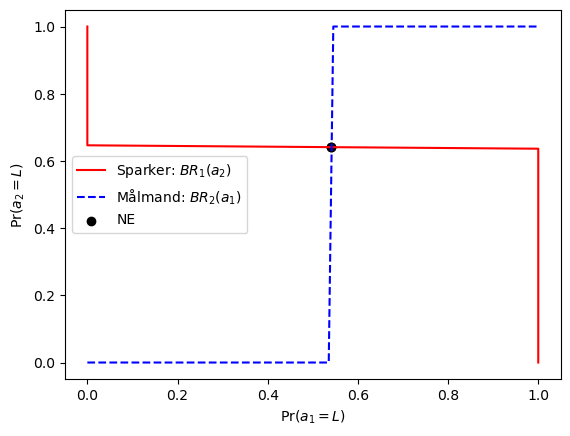

In [17]:
U1 = shares.values
U2 = -U1

plot_BR_functions_2x2(U1, U2)

# Full payoff matrix

Display overall means of the key outcome (whether a goal was scored). 

In [18]:
A = ['L','C','R'] # sequence of the actions 
goals = dat.groupby(['Kick_Direction', 'Keeper_Direction']).goal.mean().unstack().loc[A, A]
goals.round(2)

Keeper_Direction,L,C,R
Kick_Direction,,,
L,0.65,1.00,0.88
C,1.00,0.00,0.89
R,0.83,1.00,0.56


In [19]:
U = goals.values
U

array([[0.65      , 1.        , 0.88      ],
       [1.        , 0.        , 0.88888889],
       [0.83333333, 1.        , 0.55555556]])

***... continue from here...***

# A different dataset

The following dataset comes from a different source: The French and Italian elite leagues from 1997-2000, totalling 459 observations of penalty kicks. The raw micro data is not available, but Tables 3 and 4 provide us what we need to conduct the same analysis as above. 

* **Source:** Chiappori, Levitt, and Groseclose (2003): "Testing Mixed-Strategy Equilibria When Players Are Heterogeneous: The Case of Penalty Kicks in Soccer", *American Economic Review*, vol 91, no. 4. 

In [39]:
# frequency of kicks by (kicker, goalie) actions
tab = pd.DataFrame(np.array([
    [117, 48, 95],
    [4, 3, 4], 
    [85, 28, 75]
]).T, index=A, columns=A)
tab.index.name = 'Kicker' 
tab.columns.name = 'Goalie'
tab

Goalie,L,C,R
Kicker,,,
L,117,4,85
C,48,3,28
R,95,4,75


In [24]:
# the fraction of shots of each type that results in a goal
goals = pd.DataFrame(np.array([
    [63.2, 81.2, 89.5], 
    [100.0, 0., 100.0], 
    [94.1, 89.3, 44.0]
]).T / 100.0, index=A, columns=A) # we transpose to have the Kicker be player 1 
goals.index.name = 'Kicker' 
goals.columns.name = 'Goalie' 
goals

Goalie,L,C,R
Kicker,,,
L,0.63,1.00,0.94
C,0.81,0.00,0.89
R,0.90,1.00,0.44


Found 1 equilibria:
1: (array([0.43071471, 0.23768458, 0.33160071]), array([0.59066745, 0.09037212, 0.31896043]))
Player 1 expected utility: [0.76583878 0.82335512 0.71398693]
Player 2 expected utility: [-0.76333333 -0.82788671 -0.74185185]


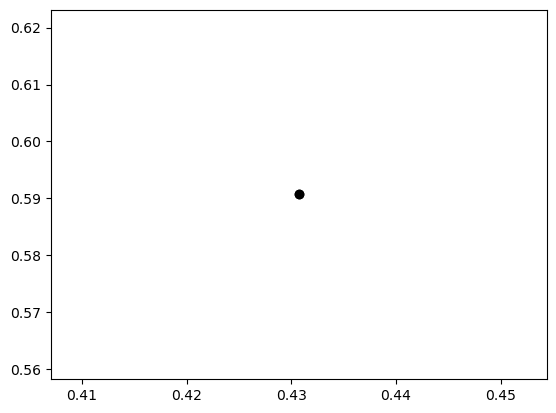

In [42]:
U_1 = np.array([
    [0.63, 1.00, 0.94],
    [0.81, 0.00, 0.89],
    [0.90, 1.00, 0.44]
])

U_2 = -U_1

solve_for_MSNE(U_1, U_2, DOPLOT=True)

emp1 = np.array([0.44880174291, 0.17211328976, 0.37908496732])
emp2 = np.array([0.56644880174, 0.02396514161, 0.409586056644])

EU_1 = U_1 @ emp2.T
EU_2 = emp1 @ U_2

print(f'Player 1 expected utility: {EU_1}')
print(f'Player 2 expected utility: {EU_2}')

Continue from here. 

Found 1 equilibria:
1: (array([0.47510397, 0.21760414, 0.30729189]), array([0.52086096, 0.18494905, 0.29418999]))
Player 1 expected utility: [0.794763  0.7928754 0.7555995]
Player 2 expected utility: [-0.7628667 -0.9418    -0.7170251]


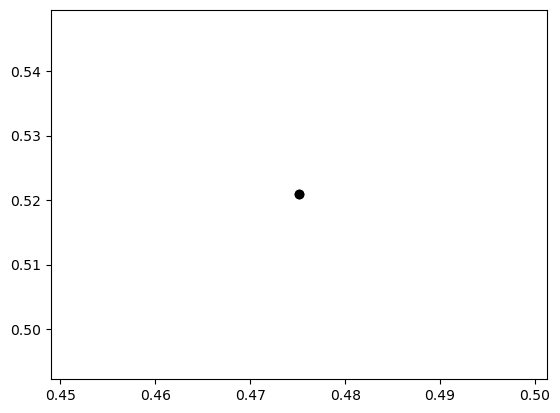

In [40]:

# Define U_1 as a numpy array
U1 = np.array([
    [0.65, 1.00, 0.88],
    [1.00, 0.00, 0.889],
    [0.833, 1.00, 0.556]
])

# Define U_2 as the negation of U_1
U2 = -U1

# Solve for the mixed-strategy Nash equilibria 
solve_for_MSNE(U1, U2, DOPLOT=True)

empirical_distribution_player_1 = np.array([0.4369, 0.0583, 0.5049])
empirical_distribution_player_2 = np.array([0.4563, 0.165, 0.3786])
Eu1 = U1 @ empirical_distribution_player_2.T  
Eu2 = empirical_distribution_player_1 @ U2

print(f'Player 1 expected utility: {Eu1}')
print(f'Player 2 expected utility: {Eu2}')